# 基于YOLOv8的三角板关键点检测模型

计算机视觉神器YOLOV8开源之后，其成为了目标检测、目标追踪、实例分割、图像分类、人体姿态估计、关键点检测等领域的新标杆

本次具体讲解如何使用YOLOv8预训练自己的数据集，进而完成模型的训练，最终实现性能的评估


## 安装YOLOv8与第三方工具包

In [ ]:
!pip install ultralytics --upgrade -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.5/617.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.153 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.2/78.2 GB disk)


In [ ]:
!pip install numpy opencv-python pillow pandas matplotlib seaborn tqdm wandb seedir emoji -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-2.7.0-py2.py3-none-any.whl size=356563 sha256=e379412e63037619623651640084e4ed4ad41264ff477321e8f134acc395cce3
  Stored in directory: /root/.cache/pip/wheels/00/16/9e/14169cbcb40ffbdc58d1ae6d1b559f333c4f9c44ed5ca22dfd
  Created wheel for p

## 下载三角板关键点检测开源数据集

In [ ]:
# 下载数据集至 datasets 目录
!rm -rf datasets/Triangle_215_Keypoint_YOLO.zip datasets/Triangle_215_Keypoint_YOLO
!wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/Triangle_215_Keypoint_YOLO.zip -P datasets

--2023-08-13 11:12:25--  https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/Triangle_215_Keypoint_YOLO.zip
Resolving zihao-download.obs.cn-east-3.myhuaweicloud.com (zihao-download.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.163, 121.36.235.162
Connecting to zihao-download.obs.cn-east-3.myhuaweicloud.com (zihao-download.obs.cn-east-3.myhuaweicloud.com)|121.36.235.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337545608 (322M) [application/zip]
Saving to: ‘datasets/Triangle_215_Keypoint_YOLO.zip’

Triangle_215_Keypoi 100%[===================>] 321.91M  41.6MB/s    in 8.2s    

2023-08-13 11:12:34 (39.1 MB/s) - ‘datasets/Triangle_215_Keypoint_YOLO.zip’ saved [337545608/337545608]



In [ ]:
# 解压
!unzip datasets/Triangle_215_Keypoint_YOLO.zip -d datasets >> /dev/null

# 删除压缩包
!rm -rf datasets/Triangle_215_Keypoint_YOLO.zip

In [ ]:
# 下载yaml配置文件
# yaml配置文件是训练YOLO格式数据集必备的文件
# 其中包含了数据集、其划分后训练集与测试集的路径；关键点的属性（类别总数：3，可见信息：不可见，遮挡，可见）与框的属性（类别总数：3）

!wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/Triangle_215.yaml

--2023-08-13 11:12:39--  https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/Triangle_215.yaml
Resolving zihao-download.obs.cn-east-3.myhuaweicloud.com (zihao-download.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.163, 121.36.235.162
Connecting to zihao-download.obs.cn-east-3.myhuaweicloud.com (zihao-download.obs.cn-east-3.myhuaweicloud.com)|121.36.235.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 483 [text/yaml]
Saving to: ‘Triangle_215.yaml’

Triangle_215.yaml   100%[===================>]     483  --.-KB/s    in 0s      

2023-08-13 11:12:39 (226 MB/s) - ‘Triangle_215.yaml’ saved [483/483]



## YOLOv8命令行参数介绍

### 总文档

https://docs.ultralytics.com/modes/train



### YOLOv8预训练模型

> yolov8n-pose.pt
>
> yolov8s-pose.pt
>
> yolov8m-pose.pt
>
> yolov8l-pose.pt
>
> yolov8x-pose.pt
>
> yolov8x-pose-p6.pt


### 参数介绍

model YOLOv8模型

data 配置文件（.yaml格式）

pretrained 是否在预训练模型权重基础上微调

epochs 训练轮次，默认100

batch batch-size，默认16

imgsz 输入图像宽高尺寸，默认640

device 计算设备（device=0 或 device=0,1,2,3（表示多卡训练） 或 device=cpu）

project 项目名称，建议同一个数据集取同一个项目名称

name 实验名称，建议每一次训练对应一个实验名称

optimizer 梯度下降优化器，默认'SGD'，备选：['SGD', 'Adam', 'AdamW', 'RMSProp']

close_mosaic 是否关闭马赛克图像扩增，默认为0，也就是开启马赛克图像扩增

cls 目标检测分类损失函数cls_loss权重，默认0.5

box 目标检测框定位损失函数box_loss权重，默认7.5


dfl 类别不均衡时Dual Focal Loss损失函数dfl_loss权重，默认1.5。

> DFL损失函数论文：Generalized Focal Loss: Learning Qualified and Distributed Bounding Boxes for Dense Object Detection
>
> DFL损失函数知乎博客：https://zhuanlan.zhihu.com/p/147691786


pose 关键点定位损失函数pose_loss权重，默认12.0（只在关键点检测训练时用到）

kobj 关键点置信度损失函数keypoint_loss权重，默认2.0（只在关键点检测训练时用到）

### 训练方式---**迁移学习**

由于三角板关键点开源数据集与MS COCO数据集**类似**（生活用品），此处选择保留预训练模型权重，并在自己的数据集上迁移学习微调分类输出层或所有层

## 正式训练

### 训练`yolov8n-pose`关键点检测模型

In [ ]:
# yolov8n-pose模型，迁移学习微调

# project 项目名称，同一个数据集取同一个项目名称； name 实验名称，每一次训练对应一个实验名称

!yolo pose train data=Triangle_215.yaml model=yolov8n-pose.pt pretrained=True project=Triangle_215 name=n_pretrain epochs=50 batch=16 device=0

100% 6.51M/6.51M [00:00<00:00, 23.9MB/s]
Ultralytics YOLOv8.0.153 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=Triangle_215.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Triangle_215, name=n_pretrain, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=

In [ ]:
# yolov8n-pose模型，随机初始权重，从头重新学习

!yolo pose train data=Triangle_215.yaml model=yolov8n-pose.pt project=Triangle_215 name=n_scratch epochs=50 batch=16 device=0

### 训练`yolov8s-pose`关键点检测模型

In [ ]:
# yolov8s-pose模型，迁移学习微调

!yolo pose train data=Triangle_215.yaml model=yolov8s-pose.pt pretrained=True project=Triangle_215 name=s_pretrain epochs=50 batch=16 device=0

In [ ]:
# yolov8s-pose模型，随机初始权重，从头重新学习

!yolo pose train data=Triangle_215.yaml model=yolov8s-pose.pt project=Triangle_215 name=s_scratch epochs=50 batch=16 device=0

### 训练`yolov8m-pose`关键点检测模型

In [ ]:
# yolov8m-pose模型，迁移学习微调

!yolo pose train data=Triangle_215.yaml model=yolov8m-pose.pt pretrained=True project=Triangle_215 name=m_pretrain epochs=50 batch=16 device=0

In [ ]:
# yolov8m-pose模型，随机初始权重，从头重新学习

!yolo pose train data=Triangle_215.yaml model=yolov8m-pose.pt project=Triangle_215 name=m_scratch epochs=50 batch=16 device=0

### 训练`yolov8l-pose`关键点检测模型

In [ ]:
# yolov8l-pose模型，迁移学习微调

!yolo pose train data=Triangle_215.yaml model=yolov8l-pose.pt pretrained=True project=Triangle_215 name=l_pretrain epochs=50 batch=4 device=0

In [ ]:
# yolov8l-pose模型，随机初始权重，从头重新学习

!yolo pose train data=Triangle_215.yaml model=yolov8l-pose.pt project=Triangle_215 name=l_scratch epochs=50 batch=4 device=0

### 训练`yolov8x-pose`关键点检测模型

In [ ]:
# yolov8x-pose模型，迁移学习微调

!yolo pose train data=Triangle_215.yaml model=yolov8x-pose.pt pretrained=True project=Triangle_215 name=x_pretrain epochs=50 batch=4 device=0

In [ ]:
# yolov8x-pose模型，迁移学习微调

!yolo pose train data=Triangle_215.yaml model=yolov8x-pose.pt pretrained=True project=Triangle_215 name=x_pretrain epochs=50 batch=4 device=0

### 训练`yolov8x-pose-p6`关键点检测模型

In [ ]:
# yolov8x-pose-p6模型，迁移学习微调

!yolo pose train data=Triangle_215.yaml model=yolov8x-pose-p6.pt pretrained=True imgsz=1280 project=Triangle_215 name=x_p6_pretrain epochs=50 batch=2 device=0

In [ ]:
# yolov8x-pose-p6模型，随机初始权重，从头重新学习

!yolo pose train data=Triangle_215.yaml model=yolov8x-pose-p6.pt imgsz=1280 project=Triangle_215 name=x_p6_scratch epochs=50 batch=2 device=0

### 获取模型权重.pt文件，用于接下来的模型部署

In [ ]:
# !wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/checkpoint/Triangle_215_yolov8n_pose_pretrain.pt -P checkpoint

# !wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/checkpoint/Triangle_215_yolov8s_pretrain.pt -P checkpoint

# !wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/checkpoint/Triangle_215_yolov8m_pretrain.pt -P checkpoint

# !wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/checkpoint/Triangle_215_yolov8l_pretrain.pt -P checkpoint

# !wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/checkpoint/Triangle_215_yolov8x_pretrain.pt -P checkpoint

# !wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/yolov8/datasets/Triangle_215_Dataset/checkpoint/Triangle_215_yolov8x_p6_pretrain.pt -P checkpoint


## 查看训练日志并实现评估指标的可视化

### 输出文件描述

**模型权重文件**

最优模型：`Project_Name/Name/weights/best.pt`

最终模型：`Project_Name/Name/weights/last.pt`

**数据集标注统计**

目标检测框的中心点位置分布、宽高分布：`labels.jpg`

目标检测框的中心点X、中心点Y、宽、高相关分布：`labels_correlogram.jpg`



**一个Batch的可视化**

`train_batch0.jpg`

`train_batch1.jpg`

`train_batch2.jpg`

**一个Batch的Prediction与Ground Truth对比**

标注：`val_batch0_labels.jpg`

预测结果：`val_batch0_pred.jpg`

标注：`val_batch1_labels.jpg`

预测结果：`val_batch1_pred.jpg`



**评估指标---框**

不同置信度的Precision：`BoxP_curve.png`

不同置信度的Recall：`BoxR_curve.png`

不同置信度的PR曲线：`BoxPR_curve.png`

不同置信度的F1：`BoxF1_curve.png`

目标检测框混淆矩阵：`confusion_matrix.png`

**评估指标---关键点**

不同置信度的Precision：`PoseP_curve.png`

不同置信度的Recall：`PoseR_curve.png`

不同置信度的PR曲线：`PosePR_curve.png`

不同置信度的F1：`PoseF1_curve.png`

**训练日志**

训练过程中的损失函数、测试集评估指标：`results.csv`、`results.png`

### 可视化处理

> 库

In [ ]:
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 创建 图表 文件夹，用于存放图表
if not os.path.exists('图表'):
    os.mkdir('图表')
    print('创建空文件夹 图表')

创建空文件夹 图表


>中文字体配置

--2023-08-13 11:43:09--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  21.0MB/s    in 6.8s    

2023-08-13 11:43:17 (17.1 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: /tmp/fonts/LICENSE_OFL.txt  
  inflating: /tmp/fonts/NotoSansCJKtc-Black.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Bold.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-DemiLight.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Light.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Medium.otf  
 

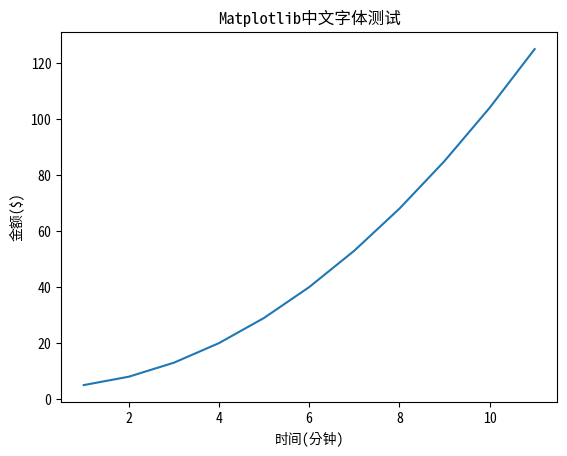

In [ ]:


# 从 Google API 上下载暂存字体放到暂存文件夹下

!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

# 指定字体
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
  font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"


#测试
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

x = np.arange(1, 12)
y = x ** 2 + 4
plt.title("Matplotlib中文字体测试")
plt.xlabel("时间(分钟)")
plt.ylabel("金额($)")
plt.plot(x,y)
plt.show()

> 载入训练日志

In [ ]:
df = pd.read_csv('/content/Triangle_215/n_pretrain/results.csv')
df.columns = [each.strip() for each in df.columns]

In [ ]:
df.head()

,epoch,train/box_loss,train/pose_loss,train/kobj_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),...,metrics/mAP50(P),metrics/mAP50-95(P),val/box_loss,val/pose_loss,val/kobj_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,2.04460,5.1166,0.68563,2.76120,2.1723,0.73025,0.78049,0.81806,0.61137,...,0.06874,0.00747,0.80241,4.8393,0.63979,1.13890,1.1426,0.000200,0.000200,0.000200
1,1,0.96003,4.6688,0.67478,0.95721,1.2358,0.86718,0.86585,0.94251,0.75415,...,0.05349,0.00590,0.72504,4.7821,0.63396,0.84643,1.1432,0.000412,0.000412,0.000412
2,2,0.81020,3.7867,0.67791,0.68128,1.1316,0.82870,0.94395,0.94355,0.72123,...,0.33107,0.04713,0.77924,3.8950,0.64275,1.31180,1.1935,0.000615,0.000615,0.000615
3,3,0.91375,3.2561,0.67731,0.70351,1.1759,0.84921,0.87805,0.91771,0.73111,...,0.71455,0.20984,0.87357,3.4151,0.61546,1.22870,1.2115,0.000809,0.000809,0.000809
4,4,0.86873,2.9127,0.65555,0.72521,1.1570,0.85077,0.87805,0.91058,0.66897,...,0.85229,0.27350,0.95725,3.1382,0.54979,1.82010,1.3863,0.000994,0.000994,0.000994


> 可视化辅助函数

In [ ]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

> YOLOv8预模型的可视化---**训练集**

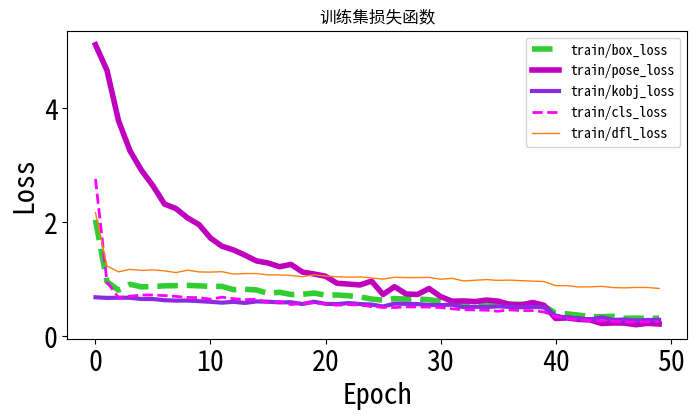

In [ ]:
# 实现损失函数的可视化

metrics = ['train/box_loss', 'train/pose_loss', 'train/kobj_loss', 'train/cls_loss', 'train/dfl_loss']


plt.figure(figsize=(8, 4))

x = df['epoch']
for y in metrics:
    plt.plot(x, df[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('训练集损失函数', fontsize=12)
plt.savefig('图表/训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=10)

plt.show()

> YOLOv8预训练模型的可视化---**测试集**

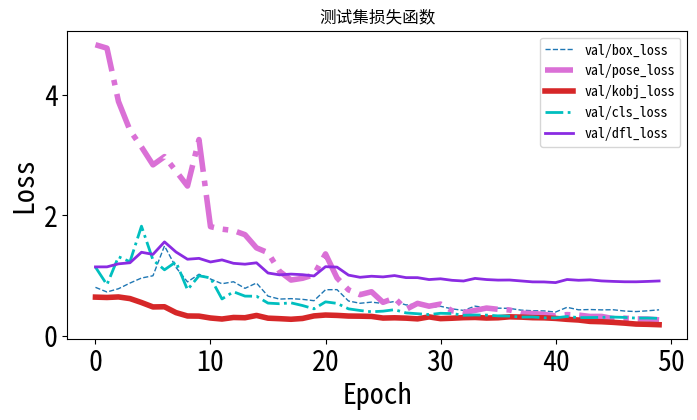

In [ ]:
# 实现损失函数的可视化

metrics = ['val/box_loss', 'val/pose_loss', 'val/kobj_loss', 'val/cls_loss', 'val/dfl_loss']


plt.figure(figsize=(8, 4))

x = df['epoch']
for y in metrics:
    plt.plot(x, df[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('测试集损失函数', fontsize=12)
plt.savefig('图表/测试集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=10)

plt.show()

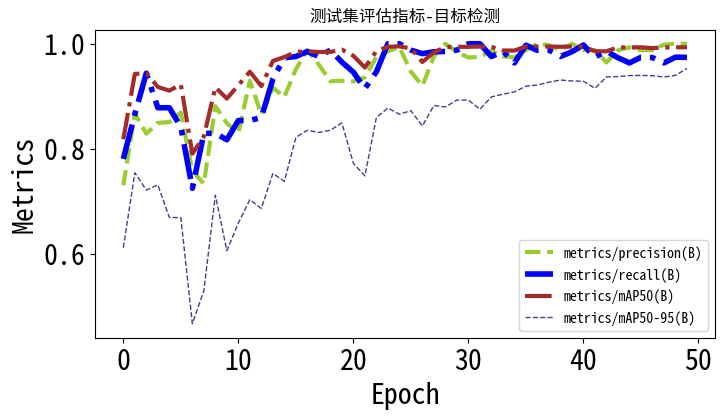

In [ ]:
# 实现目标检测（框）的可视化


metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']


plt.figure(figsize=(8, 4))

x = df['epoch']
for y in metrics:
    plt.plot(x, df[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Metrics', fontsize=20)
plt.title('测试集评估指标-目标检测', fontsize=12)
plt.savefig('图表/测试集评估指标-目标检测.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=10)

plt.show()

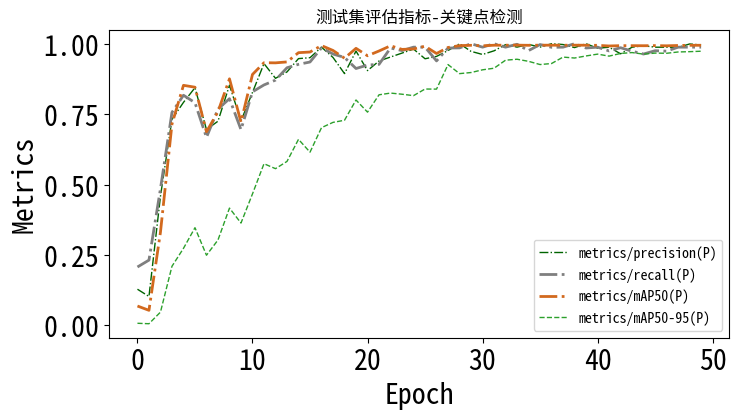

In [ ]:
# 实现关键点检测的可视化


metrics = ['metrics/precision(P)', 'metrics/recall(P)', 'metrics/mAP50(P)', 'metrics/mAP50-95(P)']


plt.figure(figsize=(8, 4))

x = df['epoch']
for y in metrics:
    plt.plot(x, df[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Metrics', fontsize=20)
plt.title('测试集评估指标-关键点检测', fontsize=12)
plt.savefig('图表/测试集评估指标-关键点检测.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=10)

plt.show()